In [1]:
import sys
sys.path.insert(0,'../')

In [2]:
import pandas as pd
import numpy as np
from utils import *
from datasets.fair_dataset import FairDataset
from IPython.display import display, Math

In [3]:
class_shift = 10

dist = {'mus': {1: np.array([10, 13]), 
                0: np.array([10 - class_shift, 13 - class_shift])},
        'sigmas': [3, 3]
       }

In [4]:
group_shift = 0
dist = {'mus':{'x1': {0: [0, 0 + group_shift], 1:[10, 10 + group_shift]},
               'z': [0, 2]},
        'sigmas': {'x1':{0: [5, 5], 1:[5, 5]},
                   'z': [1, 1]}
        }

In [5]:
protected = ["sex"]
privileged_classes = [['Male']]
kwargs = {
    'protected_attribute_names': ['sex'],
    'privileged_group': 'Male',
    'favorable_class': 1,
    'classes': [0, 1],
    'sensitive_groups': ['Female', 'Male'],
    'group_shift': 0,
    'alpha': 0.5, 'beta': 1, 'keep_im_prot': False,
    'priv_ic_prob': 0.1, 'unpriv_ic_prob': 0.4,
    'dist': dist
}
kwargs

{'protected_attribute_names': ['sex'],
 'privileged_group': 'Male',
 'favorable_class': 1,
 'classes': [0, 1],
 'sensitive_groups': ['Female', 'Male'],
 'group_shift': 0,
 'alpha': 0.5,
 'beta': 1,
 'keep_im_prot': False,
 'priv_ic_prob': 0.1,
 'unpriv_ic_prob': 0.4,
 'dist': {'mus': {'x1': {0: [0, 0], 1: [10, 10]}, 'z': [0, 2]},
  'sigmas': {'x1': {0: [5, 5], 1: [5, 5]}, 'z': [1, 1]}}}

In [6]:
estimator = get_estimator('nb', False)
keep_prot = False

In [7]:
def get_performance_summary(train_fd, test_fd, estimator, prediction_func):
    pmod, pmod_results = get_groupwise_performance(estimator, train_fd, test_fd, privileged=True)
    umod, umod_results = get_groupwise_performance(estimator, train_fd, test_fd, privileged=False)
    mod, mod_results = get_groupwise_performance(estimator, train_fd, test_fd, privileged=None)
    print(get_table_row(is_header=False, var_value='mean', p_perf=mod_results,
                        u_perf=mod_results, m_perf=mod_results, variable='method'))
    return pmod, umod, mod, pmod_results, umod_results, mod_results

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

def plot_normal(mu, sigma, ax, label=None):
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    ax.plot(x, stats.norm.pdf(x, mu, sigma), label=label)
    
def get_range(dist_table, i, j):
    mus = [l[j] for l in dist_table[:, :, 0].flatten()]
    sigmas = [l[j] for l in dist_table[:, :, 1].flatten()]
    vals = [mu - 3*sigmas[i] for i, mu in enumerate(mus)] 
    vals += [mu + 3*sigmas[i] for i, mu in enumerate(mus)]
    left = int(round(min(vals), 0))
    right = int(round(max(vals), 0))    
    return left, right
    
def plot_dist_table(dist_table, **kwargs):    
    f, ax = plt.subplots(2, 2)
    print(dist_table)
    # i controls sensitive attribute
    for i in range(2):
        # i controls class
        for j in range(2):
            mus = dist_table[i][j][0]
            sigmas = dist_table[i][j][1]
            plot_normal(float(mus[0]), float(sigmas[0]), ax[i][0])
            plot_normal(float(mus[1]), float(sigmas[1]), ax[i][1])

    for i in range(2):
        for j in range(2):
            left, right = get_range(dist_table, j, i)
            ax[j][i].set_xlim(left, right)
            ax[j][i].set_xticks([i for i in range(left, right+1) if i%5 == 0])
            ax[j][i].set_ylim(-0.01, 0.15)
            
    ax[0][0].set_title('Test Scores')
    ax[0][1].set_title('GPA')

    ax[1][0].set_ylabel('Privileged')
    ax[0][0].set_ylabel('Unprivileged')

    plt.subplots_adjust(wspace=0.25)

def plot_group_config(group_config):
    dist_table = np.reshape(group_config, (2,2,4))
    plot_dist_table(dist_table)

Test plot_dist_table()   

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


[[[list([5, 0]) list([3, 3]) 0 0]
  [list([5, 10]) list([3, 3]) 0 1]]

 [[list([0, 5]) list([3, 3]) 1 0]
  [list([10, 5]) list([3, 3]) 1 1]]]


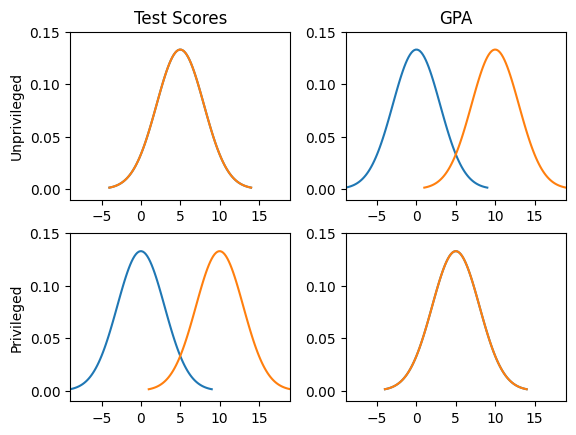

In [9]:
group_config = [
    ([5, 0], [3, 3], 0, 0),
    ([5, 10], [3, 3], 0, 1),
    ([0, 5], [3, 3], 1, 0),
    ([10, 5], [3, 3], 1, 1)
]
plot_group_config(group_config)

In [10]:
train_fd, test_fd = get_synthetic_train_test_split(
    type='corr', n_samples=10000, n_features=2,
    train_random_state=47, test_random_state=41,
    method='simple_imputer.mean', test_method='train',
    **kwargs)

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.


In [11]:
complete_df = train_fd.complete_df.astype(float)

In [12]:
for s in [0, 1]:
    for y in [0, 1]:
        sub_df = complete_df[(complete_df['sex'] == s) & (complete_df['label'] == y)]
        print(sub_df.describe())
        
for y in [0, 1]:
    sub_df = complete_df[(complete_df['label'] == y)]
    print(sub_df.describe())

                 0            1     sex   label
count  5000.000000  5000.000000  5000.0  5000.0
mean      0.033902    -0.004420     0.0     0.0
std       5.016910     5.167750     0.0     0.0
min     -16.367642   -20.253000     0.0     0.0
25%      -3.339430    -3.496689     0.0     0.0
50%       0.065087     0.015036     0.0     0.0
75%       3.407554     3.480062     0.0     0.0
max      19.650068    18.199009     0.0     0.0
                 0            1     sex   label
count  5000.000000  5000.000000  5000.0  5000.0
mean     10.060856    13.856328     0.0     1.0
std       5.075241     5.210401     0.0     0.0
min     -11.131936    -5.121390     0.0     1.0
25%       6.585877    10.198632     0.0     1.0
50%      10.041481    13.731334     0.0     1.0
75%      13.538274    17.289755     0.0     1.0
max      31.222150    31.680379     0.0     1.0
                 0            1     sex   label
count  5000.000000  5000.000000  5000.0  5000.0
mean      0.061668     0.023167     1.0 

In [13]:
train_fd.group_configs

[(array([0, 0]), array([5.        , 5.19615242]), 0, 0),
 (array([10, 14]), array([5.        , 5.19615242]), 0, 1),
 (array([0, 0]), array([5.        , 5.19615242]), 1, 0),
 (array([10, 14]), array([5.        , 5.19615242]), 1, 1)]

In [14]:
np.reshape(train_fd.group_configs, (2,2,4))

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


array([[[array([0, 0]), array([5.        , 5.19615242]), 0, 0],
        [array([10, 14]), array([5.        , 5.19615242]), 0, 1]],

       [[array([0, 0]), array([5.        , 5.19615242]), 1, 0],
        [array([10, 14]), array([5.        , 5.19615242]), 1, 1]]],
      dtype=object)

[[[array([0, 0]) array([5.        , 5.19615242]) 0 0]
  [array([10, 14]) array([5.        , 5.19615242]) 0 1]]

 [[array([0, 0]) array([5.        , 5.19615242]) 1 0]
  [array([10, 14]) array([5.        , 5.19615242]) 1 1]]]


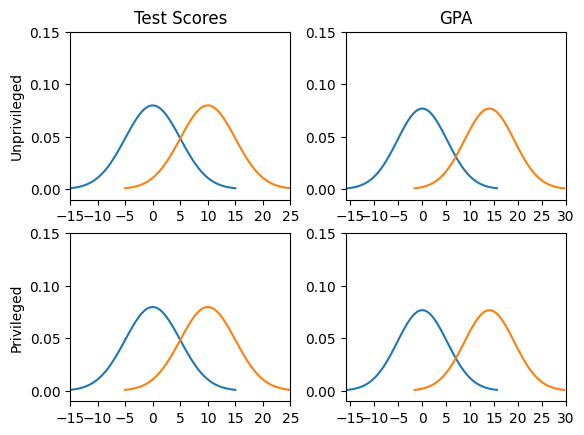

In [15]:
plot_group_config(train_fd.group_configs)

In [16]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(complete_df[complete_df.columns[:-2]], complete_df[complete_df.columns[-1]])
model.theta_

array([[4.77853114e-02, 9.37362241e-03],
       [1.00340264e+01, 1.39726829e+01]])

In [17]:
model.classes_

array([0., 1.])

In [18]:
model.var_

array([[25.17852401, 26.64481998],
       [25.34677691, 27.33494531]])

In [19]:
def get_df_group_config(df, precision=3):
    df_gc = []
    
    for s in [0, 1]:
        for l in [0, 1]:
            desc = df[((df['sex'] == s) & (df['label'] == l))].describe()
            mus = desc.loc['mean']
            sigmas = desc.loc['std']
            df_gc.append((
                [round(mus[0], precision), round(mus[1], precision)], 
                [round(sigmas[0], precision), round(sigmas[1], precision)], s, l)
            ) 
    print(*df_gc, sep='\n')
    return df_gc

([0.034, -0.004], [5.017, 5.168], 0, 0)
([10.061, 13.856], [5.075, 5.21], 0, 1)
([0.062, 0.023], [5.02, 5.157], 1, 0)
([10.007, 14.089], [4.994, 5.245], 1, 1)
[[[list([0.034, -0.004]) list([5.017, 5.168]) 0 0]
  [list([10.061, 13.856]) list([5.075, 5.21]) 0 1]]

 [[list([0.062, 0.023]) list([5.02, 5.157]) 1 0]
  [list([10.007, 14.089]) list([4.994, 5.245]) 1 1]]]


Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


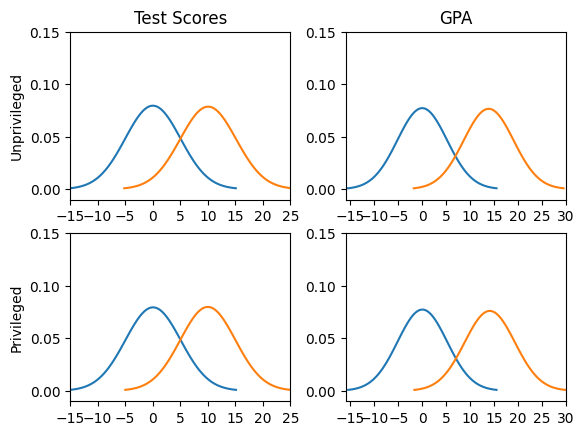

In [20]:
group_config = get_df_group_config(complete_df)
plot_group_config(group_config)

([0.034, -0.008], [5.017, 5.15], 0, 0)
([10.061, 13.81], [5.075, 5.168], 0, 1)
([0.062, 0.005], [5.02, 5.173], 1, 0)
([10.007, 14.047], [4.994, 5.255], 1, 1)
[[[list([0.034, -0.008]) list([5.017, 5.15]) 0 0]
  [list([10.061, 13.81]) list([5.075, 5.168]) 0 1]]

 [[list([0.062, 0.005]) list([5.02, 5.173]) 1 0]
  [list([10.007, 14.047]) list([4.994, 5.255]) 1 1]]]


Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


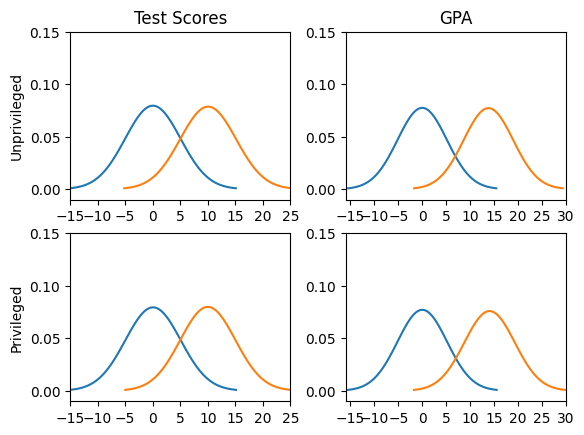

In [21]:
incomplete_df = train_fd.get_incomplete_df()
group_config = get_df_group_config(incomplete_df)
plot_group_config(group_config)

In [22]:
incomplete_df.describe()

,0,1,sex,label
count,20000.000000,15000.000000,20000.000000,20000.000000
mean,5.040906,6.976180,0.500000,0.500000
std,7.084943,8.696831,0.500013,0.500013
min,-19.312649,-21.281275,0.000000,0.000000
25%,-0.209328,-0.120766,0.000000,0.000000
50%,5.040148,6.949725,0.500000,0.500000
75%,10.306609,13.938008,1.000000,1.000000
max,31.222150,35.070891,1.000000,1.000000


([0.034, 2.786], [5.017, 5.255], 0, 0)
([10.061, 11.077], [5.075, 5.219], 0, 1)
([0.062, 0.702], [5.02, 5.335], 1, 0)
([10.007, 13.34], [4.994, 5.418], 1, 1)
[[[list([0.034, 2.786]) list([5.017, 5.255]) 0 0]
  [list([10.061, 11.077]) list([5.075, 5.219]) 0 1]]

 [[list([0.062, 0.702]) list([5.02, 5.335]) 1 0]
  [list([10.007, 13.34]) list([4.994, 5.418]) 1 1]]]
                  0             1           sex         label
count  20000.000000  20000.000000  20000.000000  20000.000000
mean       5.040906      6.991028      0.500000      0.500000
std        7.084943      8.702711      0.500013      0.500013
min      -19.312649    -21.281275      0.000000      0.000000
25%       -0.209328     -0.084612      0.000000      0.000000
50%        5.040148      7.001429      0.500000      0.500000
75%       10.306609     13.963543      1.000000      1.000000
max       31.222150     35.070891      1.000000      1.000000
                  0             1           sex         label
count  20000.000

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


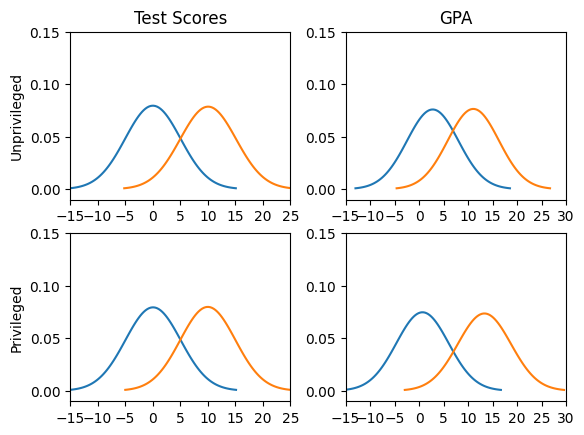

In [23]:
imputed_df = train_fd.imputed_df
group_config = get_df_group_config(imputed_df)
plot_group_config(group_config)
print(complete_df.describe())
print(imputed_df.describe())

In [24]:
get_df_group_config(imputed_df)
get_df_group_config(complete_df)

([0.034, 2.786], [5.017, 5.255], 0, 0)
([10.061, 11.077], [5.075, 5.219], 0, 1)
([0.062, 0.702], [5.02, 5.335], 1, 0)
([10.007, 13.34], [4.994, 5.418], 1, 1)
([0.034, -0.004], [5.017, 5.168], 0, 0)
([10.061, 13.856], [5.075, 5.21], 0, 1)
([0.062, 0.023], [5.02, 5.157], 1, 0)
([10.007, 14.089], [4.994, 5.245], 1, 1)


[([0.034, -0.004], [5.017, 5.168], 0, 0),
 ([10.061, 13.856], [5.075, 5.21], 0, 1),
 ([0.062, 0.023], [5.02, 5.157], 1, 0),
 ([10.007, 14.089], [4.994, 5.245], 1, 1)]

In [25]:
complete_df[complete_df['sex'] == 0].corr()

,0,1,sex,label
0,1.000000,0.565788,NaN,0.704841
1,0.565788,1.000000,NaN,0.800509
sex,NaN,NaN,NaN,NaN
label,0.704841,0.800509,NaN,1.000000


In [26]:
complete_df[complete_df['sex'] == 1].corr()

,0,1,sex,label
0,1.000000,0.559204,NaN,0.704707
1,0.559204,1.000000,NaN,0.804057
sex,NaN,NaN,NaN,NaN
label,0.704707,0.804057,NaN,1.000000


In [27]:
imputed_df[imputed_df['sex'] == 0].corr()

,0,1,sex,label
0,1.000000,0.437656,NaN,0.704841
1,0.437656,1.000000,NaN,0.620702
sex,NaN,NaN,NaN,NaN
label,0.704841,0.620702,NaN,1.000000


In [28]:
imputed_df[imputed_df['sex'] == 1].corr()

,0,1,sex,label
0,1.000000,0.530503,NaN,0.704707
1,0.530503,1.000000,NaN,0.761653
sex,NaN,NaN,NaN,NaN
label,0.704707,0.761653,NaN,1.000000


In [29]:
print(all(test_fd.complete_df == test_fd.imputed_df))
test_df = test_fd.imputed_df
get_df_group_config(test_df)

True
([0.029, 2.744], [5.076, 5.282], 0, 0)
([10.017, 11.269], [4.954, 5.39], 0, 1)
([0.024, 0.664], [4.976, 5.357], 1, 0)
([9.838, 13.375], [4.975, 5.374], 1, 1)


[([0.029, 2.744], [5.076, 5.282], 0, 0),
 ([10.017, 11.269], [4.954, 5.39], 0, 1),
 ([0.024, 0.664], [4.976, 5.357], 1, 0),
 ([9.838, 13.375], [4.975, 5.374], 1, 1)]

In [30]:
print(get_table_row(is_header=True, variable='Method'))
# output = get_performance_summary(baseline_fd, baseline_fd, estimator, get_predictions)
output = get_performance_summary(train_fd, test_fd, estimator, get_predictions)

Method	 & 	$AC_p$	 & 	$AC_u$	 & 	$SR_p$	 & 	$SR_u$	 & 	$FPR_p$	 & 	$FPR_u$\\


invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


mean	 & 	93.9	 & 	90.7	 & 	49.8	 & 	50.4	 & 	05.9	 & 	09.7\\


invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


In [31]:
pmod, umod, mod, _, _, _ = output

In [32]:
pmod.theta_

array([[ 0.06166836,  0.70191736],
       [10.00719692, 13.34033089]])

In [33]:
pmod.var_

array([[25.19231507, 28.45668246],
       [24.93919714, 29.34914187]])

In [34]:
umod.theta_

array([[ 0.03390226,  2.78573889],
       [10.06085585, 11.07673408]])

In [35]:
umod.var_

array([[25.16434745, 27.61256357],
       [25.75291701, 27.22795575]])

In [36]:
mod.theta_

array([[ 0.04778531,  1.74382812],
       [10.03402638, 12.20853249]])

In [37]:
mod.var_

array([[25.17852399, 29.12020106],
       [25.34677689, 29.56951644]])

([0.029, 2.744], [5.076, 5.282], 0, 0)
([10.017, 11.269], [4.954, 5.39], 0, 1)
([0.024, 0.664], [4.976, 5.357], 1, 0)
([9.838, 13.375], [4.975, 5.374], 1, 1)
[[[list([0.029, 2.744]) list([5.076, 5.282]) 0 0]
  [list([10.017, 11.269]) list([4.954, 5.39]) 0 1]]

 [[list([0.024, 0.664]) list([4.976, 5.357]) 1 0]
  [list([9.838, 13.375]) list([4.975, 5.374]) 1 1]]]
[5.04090585 6.9761803 ]
[<AxesSubplot:title={'center':'Test Scores'}, ylabel='Unprivileged'>, <AxesSubplot:title={'center':'GPA'}>, <AxesSubplot:ylabel='Privileged'>, <AxesSubplot:>]
5.04090584716259
5.04090584716259
6.976180304477843
6.976180304477843


Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


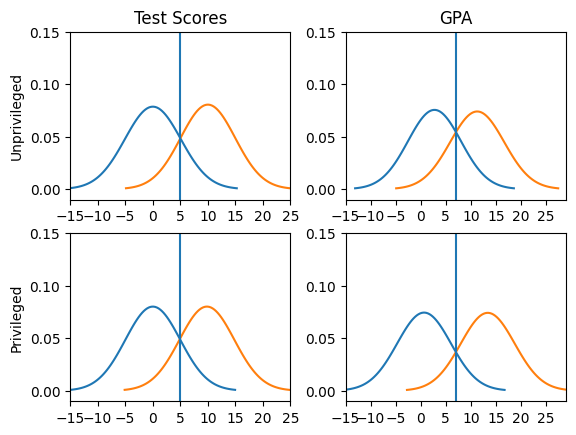

In [38]:
group_configs = get_df_group_config(test_fd.imputed_df)
plot_group_config(group_configs)
figure = plt.gcf()
axes = figure.get_axes()
means = np.mean(mod.theta_, axis=0)
print(means)
print(axes)
for i in [0, 1]:
    for j in [0, 1]:
        print(means[i])
        axes[2*i + j].axvline(means[j])

Gamma is complete case probability

In [39]:
alpha = 0.25
beta = 1
alpha_y = np.array([[alpha], [1-alpha]])
prob_s = np.array([1/(1+beta), beta/(1+beta)])
gamma_s = np.array([0.9, 0.6])

In [40]:
mu = np.array([[[1, 2], [11, 12]],
               [[0, 3], [10, 13]]])

var = np.array([[[3, 3], [3, 3]],
                [[3, 3], [3, 3]]])

In [41]:
mu_plus = (prob_s * mu[:, 1]).sum(axis=0)
mu_minus = (prob_s * mu[:, 0]).sum(axis=0)
print(mu_plus, mu_minus)

[10.5 12.5] [0.5 2.5]


In [42]:
mu_s = (alpha_y * mu).sum(axis=1)
print(mu_s)

[[ 8.5  9.5]
 [ 7.5 10.5]]


$\newcommand{\bvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\redtext}[1]{\color{red}#1\color{black}}
\newcommand{\numberthis}[0]{\stepcounter{equation}\tag{\theequation}}
\newcommand{\mynorm}[1]{\mid \mid #1 \mid \mid}
\newcommand{\dep}{\perp \!\!\! \perp}
\newcommand{\indep}{\centernot{\dep}}
\newcommand{\dsP}{P}
\newcommand{\dsE}{E}$
\begin{align*}
\dsE[\bvec{x} | \bvec{r} = \bar{0}] =& \sum_{s}{\dfrac{\gamma_s\dsP(s)}{\sum_{s}{\gamma_s \dsP(s)}}\mu^{s}}\\
\end{align*}


In [43]:
# mu_impute = ((prob_s * gamma_s * mu_s)/ (prob_s * gamma_s).sum()).sum()
mu_impute = gamma_s * mu_s
print('mu_impute', mu_impute)

mu_s_imputed = (prob_s * gamma_s) * mu_s + prob_s * (1 - gamma_s) * mu_impute
print('mu_s_imputed', mu_s_imputed)
mu_dash = mu_s_imputed.sum()
print('mu_dash', mu_dash)
assert mu_impute == mu_dash

mu_impute [[7.65 5.7 ]
 [6.75 6.3 ]]
mu_s_imputed [[4.2075 3.99  ]
 [3.7125 4.41  ]]
mu_dash 16.32


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

\begin{align*}
\dsE[\bvec{x}^\prime \mid s, y] &= \sum_{\bvec{r}}{\dsP(\bvec{r} \mid s, y)\dsE[\bvec{x}^\prime \mid \bvec{r}, s, y]}\\
&= \left[\dsP(\bvec{r}=\bar{0}|s) \dsE[\bvec{x}' \mid s, y, \bvec{r}=\bar{0}] + \dsP(\bvec{r} \neq 0 | s) \dsE[\bvec{x}' \mid s, y, \bvec{r} \neq 0]\right]\\
&= \gamma_s \dsE[\bvec{x} \mid s, y] + (1-\gamma_s) \mu_{\bvec{r}=0}\\
\end{align*}


In [ ]:
display(Math(r'$E[x^\prime | s, +]$'))
mu_prime_s_plus = gamma_s * mu_plus + (1-gamma_s) * mu_impute
print(mu_prime_s_plus)

display(Math(r'$E[x^\prime | s, -]$'))
mu_prime_s_minus = gamma_s * mu_minus + (1-gamma_s) * mu_impute
print(mu_prime_s_minus)

\begin{align*}
E[\bvec{x}^{\prime} \mid y] =& \sum_s{P(s) E[\bvec{x}^{\prime} \mid s, y]}\\
=& P(p) E[\bvec{x}^{\prime} \mid p, y] + P(u) E[\bvec{x}^{\prime} \mid u, y]\\
=& \dfrac{\beta}{1+\beta} E[\bvec{x}^{\prime} \mid p, y] + \dfrac{1}{1+\beta} E[\bvec{x}^{\prime} \mid u, y]
\end{align*}

In [ ]:
prob_s * mu_prime_s_plus + (1-prob_s) * mu_prime_s_minus

In [ ]:
# group_config = get_df_group_config(imputed_df)
# plot_group_config(group_config)
# plt.gca()
# mus = mod.theta_.mean(axis=0)
# decision_mus = np.array([mus, mus]).flatten()
# for a, x_line in zip(plt.gcf().get_axes(), decision_mus):
#     a.vlines(x_line, -1, 1)

In [ ]:
get_df_group_config(imputed_df)

In [ ]:
group_config = [
    ([0, 0], [3, 3], 0, 0),
    ([0, 0], [3, 3], 1, 0),
    ([10, 13], [3, 3], 0, 1),
    ([10, 13], [3, 3], 1, 1)
]
group_config = get_df_group_config(imputed_df)
plot_group_config(group_config)
plt.gca()
mus = mod.theta_.mean(axis=0)
decision_mus = np.array([mus, mus]).flatten()
for a, x_line in zip(plt.gcf().get_axes(), decision_mus):
    a.vlines(x_line, -1, 1)

Test data

In [ ]:
alpha = 0.5
beta = 1
alpha_y = np.array([[alpha], [1-alpha]])
prob_s = np.array([1/(1+beta), beta/(1+beta)])
gamma_s = np.array([1, 0.6])

In [ ]:
df = pd.read_csv('data.tsv', sep='\t')
print(df)

In [ ]:
def get_column_stats(df, column):
    statistics = []
    for (s, y), grp in df.groupby(['s', 'y']):
        statistics.append([s, y, grp[column].mean(), grp[column].var()])

    for s, grp in df.groupby(['s']):
        statistics.append([s, -1, grp[column].mean(), grp[column].var()])

    for y, grp in df.groupby(['y']):
        statistics.append([-1, y, grp[column].mean(), grp[column].var()])

    statistics.append([-1, -1, df[column].mean(), df[column].var()])

    statistics = pd.DataFrame(statistics, columns=['s', 'y', 'mean', 'var'])
    return statistics

In [ ]:
orig_stats = get_column_stats(df, 'x_orig')
orig_stats

$\newcommand{\bvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\redtext}[1]{\color{red}#1\color{black}}
\newcommand{\numberthis}[0]{\stepcounter{equation}\tag{\theequation}}
\newcommand{\mynorm}[1]{\mid \mid #1 \mid \mid}
\newcommand{\dep}{\perp \!\!\! \perp}
\newcommand{\indep}{\centernot{\dep}}
\newcommand{\dsP}{P}
\newcommand{\dsE}{E}$
\begin{align*}
\dsE[\bvec{x} | \bvec{r} = \bar{0}] =& \sum_{s}{\dfrac{\gamma_s\dsP(s)}{\sum_{s}{\gamma_s \dsP(s)}}\mu^{s}}\\
\end{align*}


In [ ]:
orig_stats_s = orig_stats[(orig_stats['s'] != -1) & (orig_stats['y'] == -1)]
mu_impute = (gamma_s * prob_s * orig_stats_s['mean'].values / (gamma_s * prob_s).sum()).sum()
mu_impute

In [ ]:
get_column_stats(df, 'x_miss')

Random

In [ ]:
mu_p_1 = 13
mu_p_0 = 3
mu_u_1 = 10
mu_u_0 = 0

In [ ]:
gamma_p = 0.9
gamma_u = 0.7
alpha = 0.5

In [ ]:
mu_p = alpha * mu_p_1 + (1-alpha)*mu_p_0
mu_u = alpha * mu_u_1 + (1-alpha)*mu_u_0

In [ ]:
mu_p, mu_u

In [ ]:
mu_m = (gamma_p * mu_p + gamma_u * mu_u) / (gamma_p + gamma_u)

In [ ]:
term_1 = (mu_p_1 + mu_u_1) - 2*mu_m 

In [ ]:
term_2 = -(gamma_p * mu_p_1 + gamma_u * mu_u_1) + (gamma_p + gamma_u) * mu_m

In [ ]:
term_1 > term_2

In [ ]:
mu_1_prime = 0.5*(gamma_p * mu_p_1 + gamma_u * mu_u_1) + (1 - (gamma_p + gamma_u)/ 2) * mu_m

In [ ]:
mu_1_prime

In [ ]:
mu_p_1_prime = gamma_p * mu_p_1 + (1-gamma_p) * mu_m
mu_p_0_prime = gamma_p * mu_p_0 + (1-gamma_p) * mu_m

In [ ]:
mu_p_1_prime, mu_p_0_prime

In [ ]:
mu_u_1_prime = gamma_u * mu_u_1 + (1-gamma_u) * mu_m
mu_u_0_prime = gamma_u * mu_u_0 + (1-gamma_u) * mu_m

In [ ]:
mu_u_1_prime, mu_u_0_prime

In [ ]:
mu_1_prime = (gamma_p * mu_p_1_prime + gamma_u * mu_u_1_prime)/(gamma_p + gamma_u) 

In [ ]:
mu_1_prime

In [ ]:
mu_0_prime = (gamma_p * mu_p_0_prime + gamma_u * mu_u_0_prime)/(gamma_p + gamma_u) 

In [ ]:
mu_0_prime

In [ ]:
(mu_p_1 - mu_1_prime)**2

In [ ]:
(mu_u_1 - mu_1_prime)**2